In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, CuDNNLSTM, MaxPooling2D
from keras.models import Sequential
from keras import regularizers
import keras

In [2]:
from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

In [3]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [4]:
import os
from PIL import Image
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import feature
import dlib

In [5]:
# Define emotion labels corresponding to subdirectories
emotion_labels = {'anger':0, 'disgust':1, 'fear':2, 'happy':3, 'sadness':4, 'surprise':5, 'contempt':6}
# Define a mapping dictionary from numeric labels to emotion names
emotion_names = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sadness', 5: 'surprise', 6: 'contempt'}

In [6]:
# Define the root directory where the fer2013 dataset images are stored
# Adjust the path to the actual dataset directory
dataset_dir = './CK/'

In [7]:
# Initialize empty lists to store image data and labels
images = []
labels = []

In [8]:
# Iterate through subdirectories and load images and labels
for emotion, label in emotion_labels.items():
    subdirectory_path = os.path.join(dataset_dir, emotion)
    
    # Iterate through images in each subdirectory
    for image_filename in os.listdir(subdirectory_path):
        image_path = os.path.join(subdirectory_path, image_filename)
        
        # Open and preprocess the image (you may need to resize or convert to grayscale)
        image = cv2.imread(image_path)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Append the image and its label to the lists
        image = np.array(image)  # Convert to NumPy array if needed
        images.append(image)
        labels.append(label)  # Convert emotion label to integer

In [9]:
# Convert lists to NumPy arrays for further processing
images = np.array(images)
labels = np.array(labels)
num_samples = len(images)

# Check the shapes of the arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (981, 48, 48)
Labels shape: (981,)


In [10]:
images[0].shape

(48, 48)

In [11]:
count = [0,0,0,0,0,0,0]
for i in range(num_samples):
    count[labels[i]] = count[labels[i]] + 1
for i in range(7):
    print(count[i])

135
177
75
207
84
249
54


In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [13]:
X_train = X_train/255
X_test = X_test/255

In [14]:
X_train.shape

(784, 48, 48)

In [15]:
basemodel = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64,(5,5),activation='relu', input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                        tf.keras.layers.AveragePooling2D(2,2),
                                        #tf.keras.layers.Dropout(0.25),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                        #tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                        tf.keras.layers.AveragePooling2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #tf.keras.layers.Dropout(0.25),
                                        #
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1024, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(1024, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(7, activation='softmax')
                                       ])

In [16]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 average_pooling2d (AverageP  (None, 10, 10, 64)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 64)       256       
 ormalization)                                                   
                                                        

In [17]:
basemodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.0001, decay=1e-6),
                 loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
file_name = 'best_model.h5'
checkpoint_path = os.path.join('checkpoint',file_name)
call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_freq='epoch',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='max')

In [19]:
basemodel.fit(X_train,y_train,epochs=20,validation_split=.1,callbacks=call_back)

Epoch 1/20
22/23 [===========================>..] - ETA: 0s - loss: 1.2483 - accuracy: 0.5639
Epoch 1: val_accuracy improved from -inf to 0.24051, saving model to checkpoint\best_model.h5
23/23 [==============================] - 4s 83ms/step - loss: 1.2472 - accuracy: 0.5645 - val_loss: 1.9506 - val_accuracy: 0.2405
Epoch 2/20
22/23 [===========================>..] - ETA: 0s - loss: 0.6609 - accuracy: 0.7614
Epoch 2: val_accuracy did not improve from 0.24051
23/23 [==============================] - 2s 65ms/step - loss: 0.6607 - accuracy: 0.7617 - val_loss: 1.9555 - val_accuracy: 0.0253
Epoch 3/20
22/23 [===========================>..] - ETA: 0s - loss: 0.4216 - accuracy: 0.8722
Epoch 3: val_accuracy did not improve from 0.24051
23/23 [==============================] - 2s 72ms/step - loss: 0.4226 - accuracy: 0.8709 - val_loss: 2.0133 - val_accuracy: 0.1772
Epoch 4/20
22/23 [===========================>..] - ETA: 0s - loss: 0.3125 - accuracy: 0.9006
Epoch 4: val_accuracy did not improve 

In [20]:
final_model = tf.keras.models.load_model(checkpoint_path)

In [21]:
y_pred_train = []
for i in range(784):
    y_pred = final_model.predict(tf.expand_dims(X_train[i], 0)).argmax()
    y_pred_train.append(y_pred)

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


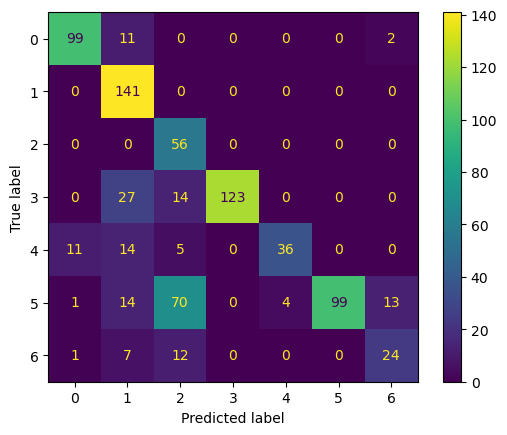

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [23]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)

print("Train Accuracy:", accuracy)
print("Classification Report:\n", report)

Train Accuracy: 0.7372448979591837
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       112
           1       0.66      1.00      0.79       141
           2       0.36      1.00      0.53        56
           3       1.00      0.75      0.86       164
           4       0.90      0.55      0.68        66
           5       1.00      0.49      0.66       201
           6       0.62      0.55      0.58        44

    accuracy                           0.74       784
   macro avg       0.77      0.75      0.71       784
weighted avg       0.85      0.74      0.74       784



In [24]:
y_pred_test = []
for i in range(197):
    y_pred = final_model.predict(tf.expand_dims(X_test[i], 0)).argmax()
    y_pred_test.append(y_pred)

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 29ms/step


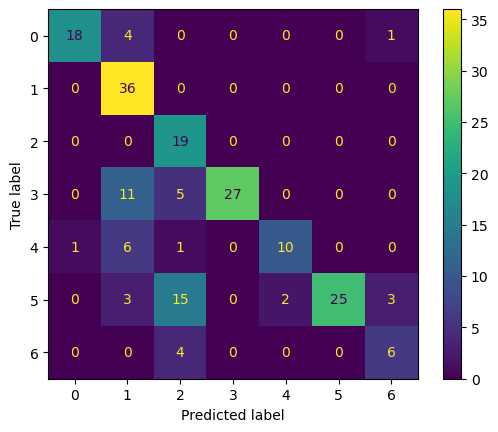

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [26]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)

Test Accuracy: 0.7157360406091371
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.78      0.86        23
           1       0.60      1.00      0.75        36
           2       0.43      1.00      0.60        19
           3       1.00      0.63      0.77        43
           4       0.83      0.56      0.67        18
           5       1.00      0.52      0.68        48
           6       0.60      0.60      0.60        10

    accuracy                           0.72       197
   macro avg       0.77      0.73      0.70       197
weighted avg       0.83      0.72      0.72       197

